# Preprocess and Split the dataset

I split the dataset into a training and testing set. Then I will reduce the number of features to only use; (1) Title, (2) Genre and (3) Movie Description. And finally I will tokenize all the data, and apply lemmatization and TF-IDF.

In [15]:
# Import all necessary packages
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from preprocess import remove_series, remove_NA
from scipy.sparse import hstack, vstack
from sklearn.cluster import KMeans


In [16]:
df = pd.read_csv('movies_with_genres.csv')
df = remove_NA(df)
df = remove_series(df)
data = df[['Name', 'Genre', 'Description']]

New Kids Turbo nan


In [17]:
data

,Name,Genre,Description
0,The Shawshank Redemption,"['Epic', 'Prison Drama', 'Drama']",A banker convicted of uxoricide forms a friend...
1,The Godfather,"['Epic', 'Gangster', 'Tragedy', 'Crime', 'Drama']",The aging patriarch of an organized crime dyna...
2,Pulp Fiction,"['Dark Comedy', 'Drug Crime', 'Gangster', 'Cri...","The lives of two mob hitmen, a boxer, a gangst..."
3,The Godfather Part II,"['Epic', 'Gangster', 'Tragedy', 'Crime', 'Drama']",The early life and career of Vito Corleone in ...
4,Inception,"['Action Epic', 'Adventure Epic', 'Psychologic...",A thief who steals corporate secrets through t...
...,...,...,...
1661,Closer,"['Steamy Romance', 'Drama', 'Romance']",The relationships of two couples become compli...
1662,Together,"['Comedy', 'Drama', 'Romance']","In 1975, the dynamics of a Swedish commune beg..."
1663,Mamma Mia!,"['Feel-Good Romance', 'Jukebox Musical', 'Pop ...","Donna, an independent hotelier, is preparing f..."
1664,Switchblade Romance,"['Psychological Horror', 'Slasher Horror', 'Ho...",Best friends Marie and Alexia decide to spend ...


In [18]:
# Process descriptions
import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
import regex as re

def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None
    

def tokenize_with_context(column):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    data_col = []
    for index, doc in enumerate(column):
        pos_tags = nltk.pos_tag(nltk.word_tokenize(doc))
        wordnet_tags = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tags))

        lemmatized_tokens = []
        for word, tag in wordnet_tags:
            if tag is None:
                # if there is no available tag, append the token as is
                lemmatized_tokens.append(str(word).lower())
            else:        
                # else use the tag to lemmatize the token
                lemma = lemmatizer.lemmatize(word, tag)
                lemmatized_tokens.append(lemma.lower())

        tokens_removed_char = [re.sub(r'[^a-zA-Z]', '', w) for w in lemmatized_tokens]
        final_tokens = [word for word in tokens_removed_char if word and word not in stop_words]

        data_col.append(final_tokens)
        
    return data_col

In [19]:
def preprocess_tfidf(dataset):
    
    tfidf_vec = TfidfVectorizer(
    preprocessor=None, 
    tokenizer=lambda x: x, 
    analyzer='word', 
    stop_words=None, 
    lowercase=False,
    token_pattern=r"(?u)\b\w\w+\b")

    title = tokenize_with_context(dataset['Name'])
    genres = tokenize_with_context(dataset['Genre'])
    description = tokenize_with_context(dataset['Description'])

    tfidf_title = tfidf_vec.fit_transform(title)
    tfidf_genres = tfidf_vec.fit_transform(genres)
    tfidf_description = tfidf_vec.fit_transform(description)

    print(tfidf_title.shape)
    print(tfidf_genres.shape)
    print(tfidf_description.shape)

    tfidf_result = hstack((tfidf_title, tfidf_genres, tfidf_description))
    print(tfidf_result.shape)
    return tfidf_result


In [20]:
new_dataset = pd.DataFrame(data)
new_dataset['Name'] = tokenize_with_context(data['Name'])
new_dataset['Genre'] = tokenize_with_context(data['Genre'])
new_dataset['Description'] = tokenize_with_context(data['Description'])

In [21]:
new_dataset

,Name,Genre,Description
0,"[shawshank, redemption]","[epic, prison, drama, drama]","[banker, convict, uxoricide, form, friendship,..."
1,[godfather],"[epic, gangster, tragedy, crime, drama]","[age, patriarch, organize, crime, dynasty, tra..."
2,"[pulp, fiction]","[dark, comedy, drug, crime, gangster, crime, d...","[life, two, mob, hitman, boxer, gangster, wife..."
3,"[godfather, part, ii]","[epic, gangster, tragedy, crime, drama]","[early, life, career, vito, corleone, new, yor..."
4,[inception],"[action, epic, adventure, epic, psychological,...","[thief, steal, corporate, secret, use, dreamsh..."
...,...,...,...
1661,[closer],"[steamy, romance, drama, romance]","[relationship, two, couple, become, complicate..."
1662,[together],"[comedy, drama, romance]","[dynamic, swedish, commune, begin, change, upo..."
1663,"[mamma, mia]","[feelgood, romance, jukebox, musical, pop, mus...","[donna, independent, hotelier, prepare, daught..."
1664,"[switchblade, romance]","[psychological, horror, slasher, horror, horror]","[best, friend, marie, alexia, decide, spend, q..."


In [22]:
X_train, X_test = train_test_split(data, train_size=0.8)

# Apply results of TF-IDF to K-Means Model

I will take the results of having applied TF-IDF to the previously mentioned features, and first apply PCA to it (to be able to plot it). Then I will fit a K-Means Model to the PCA transformed results. 

In [23]:
X_train_preprocessed = preprocess_tfidf(X_train)

(1332, 1722)
(1332, 153)
(1332, 6075)
(1332, 7950)


c:\Users\User\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


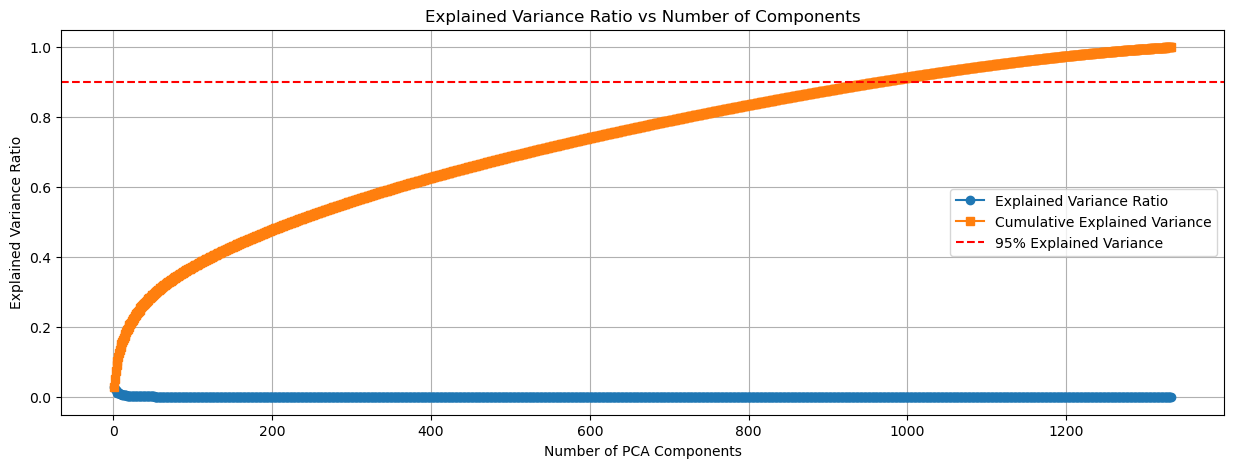

In [ ]:
# Fit PCA
pca = PCA()
pca.fit(X_train_preprocessed.toarray())

# Extract explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Plot explained variance ratio
plt.figure(figsize=(15, 5))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', label='Explained Variance Ratio')
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='s', label='Cumulative Explained Variance')

# Add labels and legend
plt.xlabel('Number of PCA Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio vs Number of Components')
plt.axhline(y=0.90, color='r', linestyle='--', label='90% Explained Variance')  # Optional threshold
plt.legend(loc='best')
plt.grid()
plt.show()

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows wi

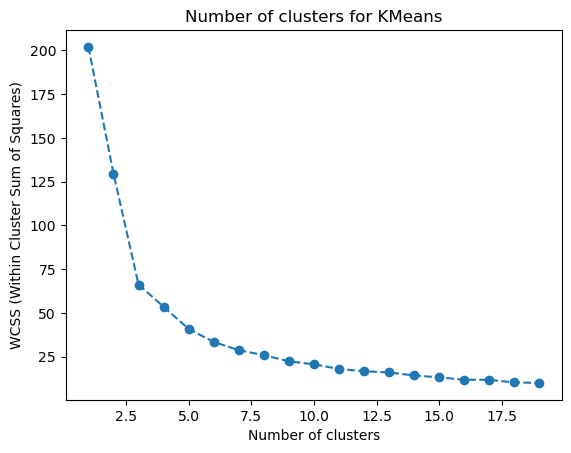

In [24]:
pca1 = PCA(n_components=2)
pca1_res = pca1.fit_transform(X_train_preprocessed.toarray())
num_clusters = []
for i in range(1, 20):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(pca1_res)
    num_clusters.append(kmeans.inertia_)

plt.plot(range(1, 20), num_clusters, linestyle = '--', marker = 'o')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS (Within Cluster Sum of Squares)')
plt.title('Number of clusters for KMeans')
plt.show()

In [28]:
kmeans_4c = KMeans(n_clusters=4, random_state=42)
clusters_4c = kmeans_4c.fit_predict(pca1_res)
centroids_4c = kmeans_4c.cluster_centers_


# Apply K-means clustering to the PCA results
kmeans_5c = KMeans(n_clusters=5, random_state=42)
clusters_5c = kmeans_5c.fit_predict(pca1_res)
centroids_5c = kmeans_5c.cluster_centers_


c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


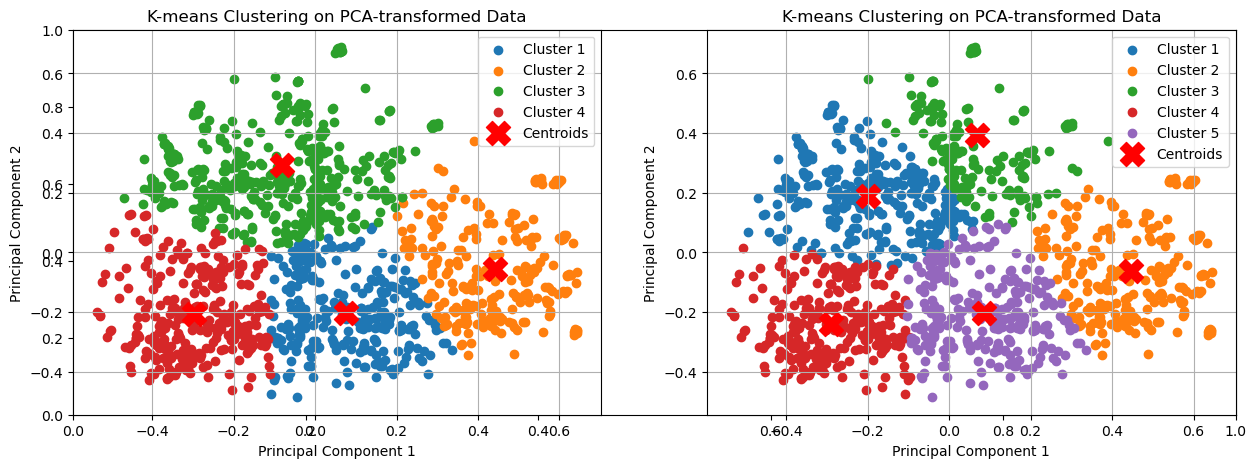

In [ ]:
plt.subplots(figsize=(15, 5))
plt.subplot(1, 2, 1)
# Scatterplot of PCA results with clusters
for cluster in range(4):
    plt.scatter(
        pca1_res[clusters_4c == cluster, 0], 
        pca1_res[clusters_4c == cluster, 1], 
        label=f"Cluster {cluster + 1}"
    )

# Plot centroids
plt.scatter(centroids_4c[:, 0], centroids_4c[:, 1], s=300, c='red', marker='X', label='Centroids')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-means Clustering on PCA-transformed Data')
plt.legend()
plt.grid()

# Scatterplot of PCA results with clusters
plt.subplot(1, 2, 2)
for cluster in range(5):
    plt.scatter(
        pca1_res[clusters_5c == cluster, 0], 
        pca1_res[clusters_5c == cluster, 1], 
        label=f"Cluster {cluster + 1}"
    )

# Plot centroids
plt.scatter(centroids_5c[:, 0], centroids_5c[:, 1], s=300, c='red', marker='X', label='Centroids')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-means Clustering on PCA-transformed Data')
plt.legend()
plt.grid()

In [27]:
df_train = pd.DataFrame(X_train)

X_train_4clusters = pd.DataFrame(clusters_4c, columns=['Cluster'])
X_train_4clusters.set_index(df_train.index.values)

X_train_5clusters = pd.DataFrame(clusters_5c, columns=['Cluster'])
X_train_5clusters.set_index(df_train.index.values)

,Cluster
106,3
1655,3
961,1
592,2
511,1
...,...
1074,3
815,3
836,1
630,2


# Test the recommendation performance of the K-Means model

I will take the movies from the test set and test what recommendations they will produce for both of the models; (1) K-Means with 4 clusters and (2) K-Means with 5 clusters.
It will use the Cosine similarity method to select the 5 closest datapoints to the input movie (within the clusters it was assigned).

In [33]:
X_test_preprocessed = preprocess_tfidf(X_test)
pca_test_results = pca1.fit_transform(X_test_preprocessed.toarray())

(334, 570)
(334, 136)
(334, 2552)
(334, 3258)


c:\Users\User\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [79]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances


print(pd.DataFrame(X_test).iloc[5])
input_movie = pca_test_results[5].reshape(1, -1)
print(input_movie)

input_movie_cluster = kmeans_5c.predict(input_movie)[0]
cluster_movies = X_train_5clusters[X_train_5clusters['Cluster'] == input_movie_cluster]
cluster_movies['Similarity'] = -euclidean_distances(input_movie, pca1_res[X_train_5clusters['Cluster'] == input_movie_cluster]).flatten()
#cluster_movies['Similarity'] = cosine_similarity(input_movie, pca1_res[X_train_5clusters['Cluster'] == input_movie_cluster]).flatten()

Name                       Anchorman: The Legend of Ron Burgundy
Genre                              ['Farce', 'Satire', 'Comedy']
Description    In the 1970s, an anchorman's stint as San Dieg...
Name: 937, dtype: object
[[0.36177938 0.0526624 ]]


C:\Users\User\AppData\Local\Temp\ipykernel_24844\3108751034.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_movies['Similarity'] = -euclidean_distances(input_movie, pca1_res[X_train_5clusters['Cluster'] == input_movie_cluster]).flatten()


In [80]:
combined = pd.merge(cluster_movies, df_train, left_index=True, right_index=True)
recommendations = combined.sort_values(by='Similarity', ascending=False)
recommendations.head(5)

,Cluster,Similarity,Name,Genre,Description
169,1,-0.000600,The 40 Year-Old Virgin,"['Feel-Good Romance', 'Raunchy Comedy', 'Roman...","Goaded by his buddies, a nerdy guy who's never..."
382,1,-0.025894,Underworld: Evolution,"['Action', 'Fantasy', 'Thriller']","Picking up directly from the previous movie, v..."
849,1,-0.034096,Kung Fu Panda,"['Animal Adventure', 'Computer Animation', 'Ku...","To everyone's surprise, including his own, Po,..."
1285,1,-0.038929,Dial M for Murder,"['Crime', 'Thriller']",A former tennis star arranges the murder of hi...
935,1,-0.044215,Stranger Than Fiction,"['Comedy', 'Drama', 'Fantasy', 'Romance']",I.R.S. auditor Harold Crick suddenly finds his...


It is worth noting that due to the fact that each of the 5 clusters are relatively large, the range of movies within each cluster is also very large. This leads to some movie recommendations being less optimal than others. As an example, you could consider the recommendations for the movie; "Anchorman: The Legend of Ron Burgundy", and compare those to the ones that were recommended for the family movie; "Shrek Forever After". 

The recommendations based on this movie; "Anchorman: The Legend of Ron Burgundy" was;
- The 40 Year-Old Virgin
- Gangs of New York	
- Avatar
- Kung Fu Panda
- Jeff, Who Lives at Home

And the recommendations based on this movie; "Shrek Forever After" was;
- I Am Legend
- The Ninth Gate	
- Titanic
- Shaft
- District 9

# Apply results of TF-IDF to a Density-based Spatial Clustering of Applications with Noise (DBSCAN) Model

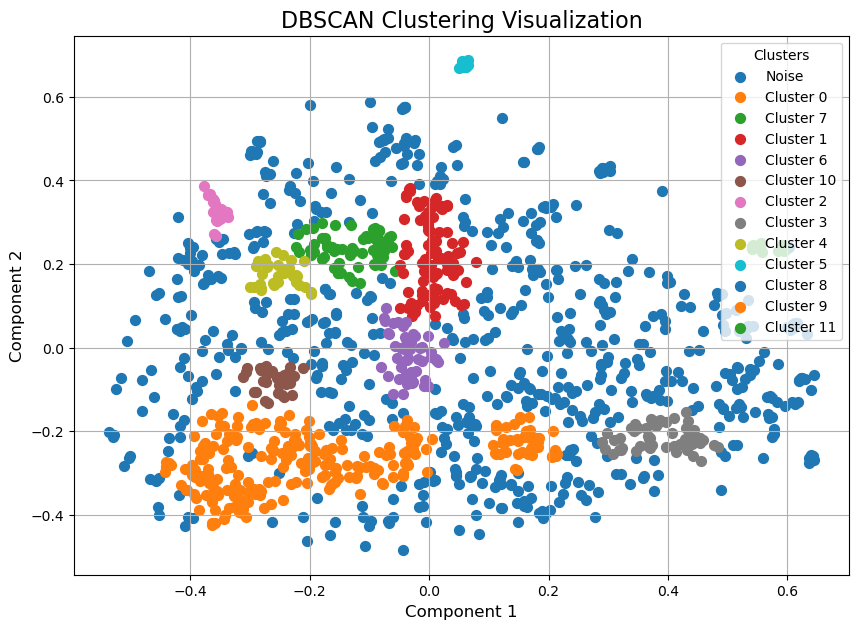

In [98]:
db_model = DBSCAN(eps=0.04, min_samples=15)
db_model.fit(pca1_res)

db_labels = db_model.labels_
# Building the label to colour mapping 

df_plot = pd.DataFrame(pca1_res, columns=['Component 1', 'Component 2'])
df_plot['Cluster'] = db_model.labels_

clusters = df_plot['Cluster'].unique()
colors = plt.cm.tab10(np.linspace(0, 1, len(clusters)))  # Generate distinct colors
color_map = {cluster: color for cluster, color in zip(clusters, colors)}

plt.figure(figsize=(10, 7))
for cluster in clusters:
    cluster_data = df_plot[df_plot['Cluster'] == cluster]
    plt.scatter(
        cluster_data['Component 1'],
        cluster_data['Component 2'],
        #color=color_map[cluster],
        label=f"Cluster {cluster}" if cluster != -1 else "Noise",
        s=50  # Point size
    )

# Add title, labels, and legend
plt.title('DBSCAN Clustering Visualization', fontsize=16)
plt.xlabel('Component 1', fontsize=12)
plt.ylabel('Component 2', fontsize=12)
plt.legend(loc='upper right', title='Clusters')
plt.grid(True)
plt.show()

In [101]:
merged = pd.merge(df_plot, df_train, left_index=True, right_index=True)
merged[merged['Cluster'] == 5]

,Component 1,Component 2,Cluster,Name,Genre,Description
36,0.058132,0.679323,5,Day of the Dead,"['Zombie Horror', 'Action', 'Horror', 'Sci-Fi'...",When a small Colorado town is overrun by the f...
53,0.060185,0.672488,5,Downfall,"['Docudrama', 'Political Drama', 'Biography', ...","Traudl Junge, the final secretary for Adolf Hi..."
118,0.054944,0.676134,5,Watchmen,"['Dystopian Sci-Fi', 'Superhero', 'Action', 'D...","In a version of 1985 where superheroes exist, ..."
147,0.061194,0.675384,5,Wanted,"['Gun Fu', 'Superhero', 'Action', 'Crime', 'Th...",A frustrated office worker discovers that he i...
224,0.057800,0.673944,5,The Day After Tomorrow,"['Disaster', 'Survival', 'Action', 'Adventure'...","Jack Hall, paleoclimatologist, must make a dar..."
281,0.056707,0.676999,5,Click,"['High-Concept Comedy', 'Supernatural Fantasy'...",A workaholic architect finds a universal remot...
309,0.063856,0.676790,5,1408,"['Supernatural Horror', 'Fantasy', 'Horror', '...",Author Michael Enslin specializes in debunking...
410,0.056612,0.682131,5,Along Came Polly,"['Romantic Comedy', 'Comedy', 'Romance']",A buttoned-up newlywed finds his strictly orga...
412,0.061180,0.675131,5,District 13: Ultimatum,"['Martial Arts', 'Action', 'Crime', 'Thriller']",Damien and Leito return to District 13 on a mi...
420,0.057471,0.676363,5,Mary Poppins,"['Classic Musical', 'Comedy', 'Family', 'Fanta...","In turn of the century London, a magical nanny..."


The data appears to be too sparse to be able to select a fitting set of parameters for the DBSCAN method. This means that regardless of what parameters I choose, no significant clusters form, and a large amount of the data is either clustered into one cluster or labelled as noise. This leads to it not being the most effective choice for the current dataset.

# Apply results of TF-IDF to a Hierarchical Clustering Model

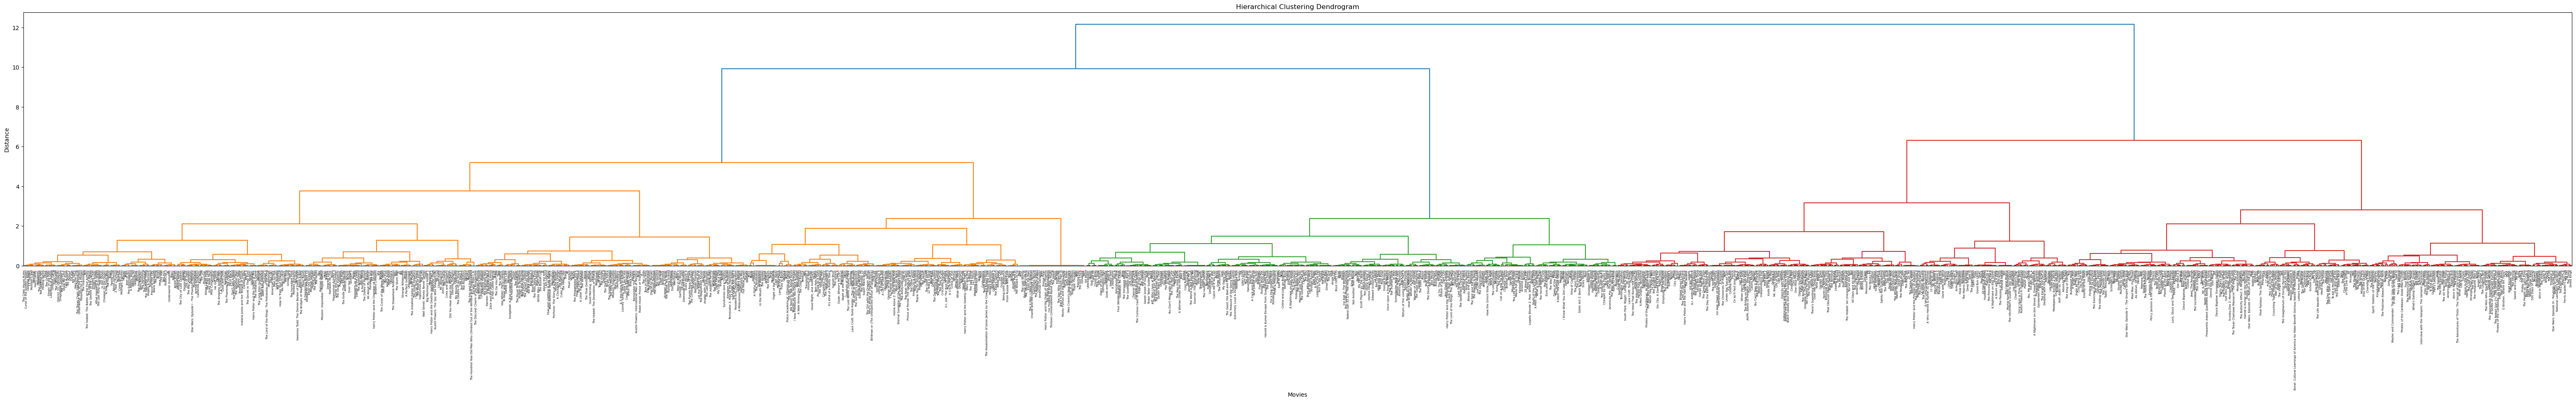

In [108]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

# Perform hierarchical clustering
linked = linkage(pca1_res, method='ward')  # Use Ward's method

# Plot dendrogram
plt.figure(figsize=(80, 8))
dendrogram(linked,
           orientation='top',
           labels=df_train['Name'].values,
           distance_sort='descending',
           show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Movies')
plt.ylabel('Distance')
plt.show()


In [116]:
# Agglomerative clustering to extract cluster labels
n_clusters = 10  # Choose the number of clusters
cluster_model = AgglomerativeClustering(n_clusters=n_clusters, metric='cosine', linkage='average')
cluster_labels = cluster_model.fit_predict(pca1_res)

# Add cluster labels to the dataset
df_train['Cluster'] = cluster_labels
df_train


,Name,Genre,Description,Cluster
0,The Shawshank Redemption,"['Epic', 'Prison Drama', 'Drama']",A banker convicted of uxoricide forms a friend...,9
1,The Godfather,"['Epic', 'Gangster', 'Tragedy', 'Crime', 'Drama']",The aging patriarch of an organized crime dyna...,2
2,Pulp Fiction,"['Dark Comedy', 'Drug Crime', 'Gangster', 'Cri...","The lives of two mob hitmen, a boxer, a gangst...",7
3,The Godfather Part II,"['Epic', 'Gangster', 'Tragedy', 'Crime', 'Drama']",The early life and career of Vito Corleone in ...,4
4,Inception,"['Action Epic', 'Adventure Epic', 'Psychologic...",A thief who steals corporate secrets through t...,3
...,...,...,...,...
1660,Exam,"['Psychological Thriller', 'Crime', 'Mystery',...",Eight candidates for a highly desirable corpor...,5
1661,Closer,"['Steamy Romance', 'Drama', 'Romance']",The relationships of two couples become compli...,3
1662,Together,"['Comedy', 'Drama', 'Romance']","In 1975, the dynamics of a Swedish commune beg...",7
1663,Mamma Mia!,"['Feel-Good Romance', 'Jukebox Musical', 'Pop ...","Donna, an independent hotelier, is preparing f...",1


Testing the recommendation part of the system using a Hierarchical Clustering Model: